In [0]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

# Load cleaned Delta files
sales_df = spark.read.format("delta").load("/mnt/cleaned_data/sales_df")
segment_df = spark.read.format("delta").load("/mnt/cleaned_data/segment_df")
profile_df = spark.read.format("delta").load("/mnt/cleaned_data/profile_df")

In [0]:
from pyspark.sql.functions import rand, col

# Generate Age between 20 and 60
profile_df = profile_df.withColumn("Age", (rand() * 40 + 20).cast("int"))

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.sql.functions import current_date, col, months_between, when

# Assume "Last_Purchase_Date" exists in profile_df
profile_df = profile_df.withColumn("Churn", when(months_between(current_date(), col("Last_Purchase_Date")) > 6, 1).otherwise(0)).withColumn("Age", col("Age"))

# Feature assembly
features = ["Age", "Tenure_Months"]
assembler = VectorAssembler(inputCols=features, outputCol="features")

# Model training
lr = LogisticRegression(labelCol="Churn", featuresCol="features")
pipeline = Pipeline(stages=[assembler, lr])
model = pipeline.fit(profile_df)

# Predictions
predictions = model.transform(profile_df)
predictions.select("Customer_ID", "Churn", "prediction", "probability").show(10)

+-----------+-----+----------+--------------------+
|Customer_ID|Churn|prediction|         probability|
+-----------+-----+----------+--------------------+
|       C000|    1|       1.0|[0.00368598726355...|
|       C001|    1|       1.0|[0.03433760676443...|
|       C002|    1|       1.0|[0.01838070941743...|
|       C003|    1|       1.0|[0.00154703459473...|
|       C004|    1|       1.0|[0.00101087731441...|
|       C005|    1|       1.0|[0.00144444276219...|
|       C006|    1|       1.0|[7.93166870782751...|
|       C007|    1|       1.0|[0.05140992914574...|
|       C008|    1|       1.0|[0.00255797899424...|
|       C009|    1|       1.0|[0.00560711324314...|
+-----------+-----+----------+--------------------+
only showing top 10 rows



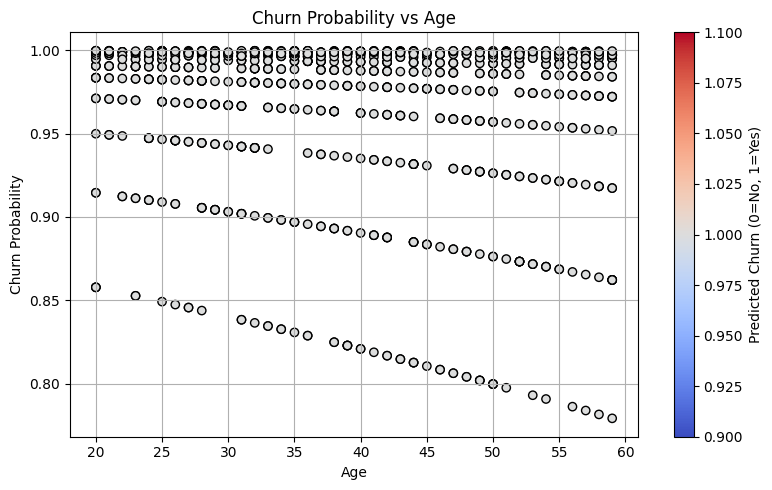

In [0]:
import matplotlib.pyplot as plt

# Convert Spark predictions to pandas for plotting
pdf = predictions.select("Age", "Tenure_Months", "probability", "prediction").toPandas()

# Extract churn probability (probability[1] is the probability of churn)
pdf["Churn_Probability"] = pdf["probability"].apply(lambda x: float(x[1]))

# Plot: Churn Probability vs Age
plt.figure(figsize=(8, 5))
plt.scatter(pdf["Age"], pdf["Churn_Probability"], c=pdf["prediction"], cmap='coolwarm', edgecolor='k')
plt.xlabel("Age")
plt.ylabel("Churn Probability")
plt.title("Churn Probability vs Age")
plt.colorbar(label='Predicted Churn (0=No, 1=Yes)')
plt.grid(True)
plt.tight_layout()

# Save plot to Databricks DBFS path


In [0]:

from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# Extract probability of churn from vector
extract_prob = udf(lambda v: float(v[1]), DoubleType())
pred_df = predictions.withColumn("Churn_Probability", extract_prob("probability")) \
                     .select("Customer_ID", "Age", "Tenure_Months", "Churn", "prediction", "Churn_Probability")

In [0]:
jdbc_url = "jdbc:sqlserver://geeta.database.windows.net:1433;databaseName=db_dev"

connection_properties = {
    "user": "geeta@geeta",  
    "password": "Chaitu@13",  
    "driver": "com.microsoft.sqlserver.jdbc.SQLServerDriver"
}


In [0]:
pred_df.write.jdbc(
    url=jdbc_url,
    table="Churn_Predictions",
    mode="overwrite",  # or "append"
    properties=connection_properties
)